In [1]:
name = "New York"
src = "new_york"                # source of annotated data
feets_per_inch = 333.33         # scale of the map
n0 = 0                          # index of the first node
n1 = "(3, 40.74605893499274, -73.99053528624474)"   # (index, lat, lon) of another node connected to n0
d_n0_n1 = 259.19                # distance between n0 and n1 in feet

Pois categories:
- entertainment
- commercial
- catering
- service
- office
- leisure
- natural
- education
- building.historic
- heritage
- tourism
- accomodation
- pet
- healthcare
- administrative
- production
- religion
- amenity
- public transport

Nodes features:
- crosswalk
- walk light
- round-about
- walk light duration
- street width
- tactile paving

Edges features:
- work in progress
- bike lane
- uphill
- surface
- one way
- tactile paving
- stairs

Pois features:
- wheelchair accessible
- tactile paving
- tactile map
- reception
- stairs
- elevators

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import json

In [3]:
out = f"{src}/{src}_out"

In [4]:
!python3.8 src/format.py --name "{name}" --n0 {n0} --n1 "{n1}" --d_feets {d_n0_n1} --feets_per_inch {feets_per_inch}  --src_dir "{src}"

Seed: 1727853367.763773
Feets per pixel: 2.0978965222031607
Could not find edge for Sushi Ginza Onodera
Could not find edge for Pig 'N' Whistle On 36th
Could not find edge for Calle Dao
Could not find edge for Wolfgang’s Steakhouse
Could not find edge for The Crooked Knife
Could not find edge for on
Could not find edge for Prosek
Could not find edge for Mondo
Could not find edge for Nomad
Could not find edge for Sweetgreen
Could not find edge for The Redbury New York
Citizens Bank (24) is too close to node 0
Bank of America (15) is too close to node 3
Nuchas (48) is too close to node 21
Chick-fil-A (23) is too close to node 55
28th Street (0) is too close to Dig (28)
32nd Street (1) is too close to The Harold (60)
32nd Street & 5th Avenue (2) is too close to IchiUmi (34)
5th Avenue & 32nd Street (7) is too close to 5th Avenue & West 33rd Street (8)
6th Avenue & West 31st Street (9) is too close to O'Reilly's Pub (49)
American Academy of Dramatic Arts (12) is too close to Blank Slate Co

In [5]:
def distance(p1, p2):
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

def get_label(name: str):
    name.replace("-", " ")
    name.replace("_", " ")

    label = ""
    for word in name.split(" "):
        if len(word) > 2 and word[:-2].isnumeric():
            label += word[:-2]
        else: label += word[0]
    return label

def get_contrasting_color(color):
    rgb = mcolors.to_rgb(color)
    brightness = 0.299 * rgb[0] + 0.587 * rgb[1] + 0.114 * rgb[2]
    return 'white' if brightness < 0.5 else 'black'

In [6]:
G = nx.Graph()

with open(f'{out}/nodes.json') as f:
    nodes = json.load(f)

for i, node in enumerate(nodes):
    G.add_node(i, pos=(node[0], node[1]))

with open(f'{out}/edges.json') as f:
    edges = json.load(f)

with open(f'{out}/streets.json', 'r') as f:
    streets = json.load(f)

for street, street_edges in streets.items():
    street = street.replace("Street", "St")
    street = street.replace("Avenue", "Ave")
    street = street.replace("Boulevard", "Blvd")
    street = street.replace("Road", "Rd")

    for edge_index in street_edges:
        edge = edges[edge_index]

        n1 = G.nodes[edge[0]]['pos']
        n2 = G.nodes[edge[1]]['pos']
        dist = distance(n1, n2)
        G.add_edge(edge[0], edge[1], weight=dist, street=street)

with open(f'{out}/pois.json') as f:
    pois = json.load(f)
    pois.sort(key=lambda x: get_label(x['name']))

print(f"PoIs found: {len(pois)}")

PoIs found: 76


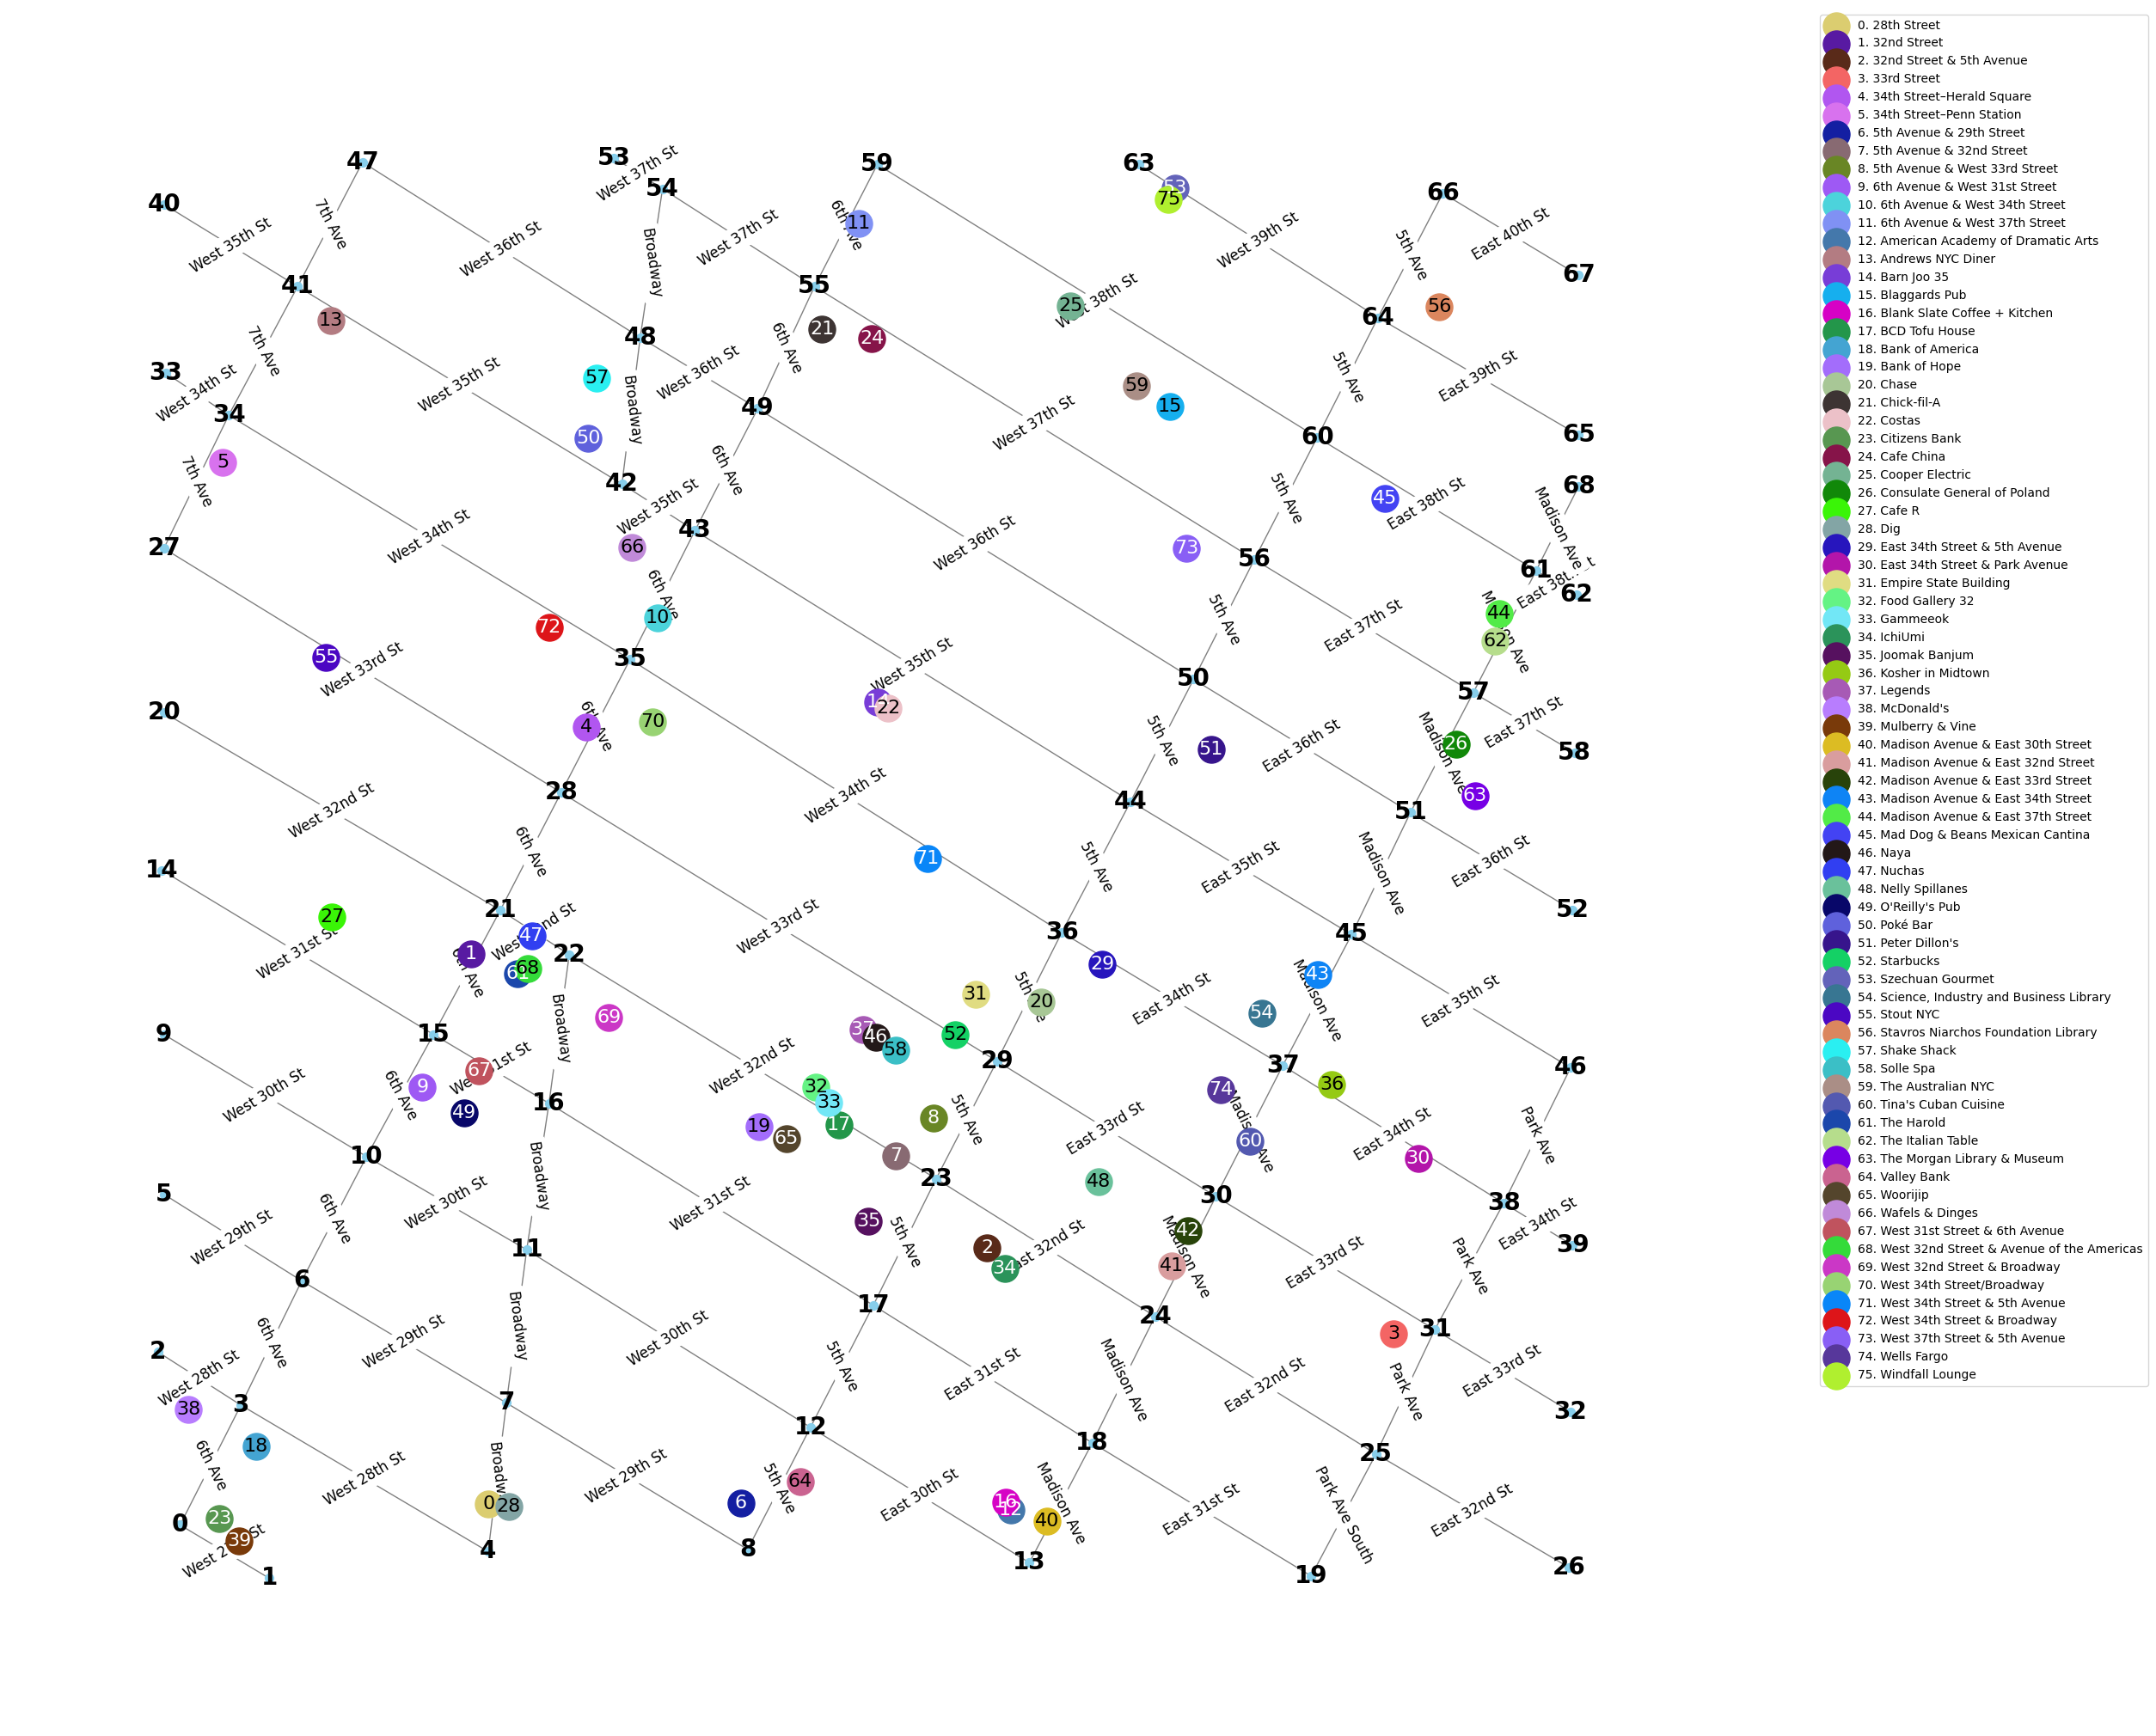

In [7]:
pos = nx.get_node_attributes(G, "pos")

plt.figure(figsize=(20, 20))

nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=50,
    node_color="skyblue",
    font_size=20,
    font_color="black",
    font_weight="bold",
    edge_color="gray",
)

labels = nx.get_edge_attributes(G, "street")
#labels = {k: round(v, 2) for k, v in labels.items()}
#labels = {k: get_label(v) for k, v in labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=12)

colors = np.random.rand(len(pois), 3)
for i, poi in enumerate(pois):
    coords = poi["coords"]
    dot = plt.scatter(
        coords[0], coords[1], color=colors[i], s=500, label=f"{i}. {poi['name']}"
    )
    text_color = get_contrasting_color(colors[i])
    plt.text(coords[0], coords[1], i, fontsize=16, c=text_color, ha="center", va="center")

plt.gca().invert_yaxis()
plt.gcf().set_size_inches(20, 20)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.savefig(f"{out}/plot.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

In [8]:
offset = 0
for i, poi in enumerate(pois[offset:]):
    print(f"{i + offset}. {poi['name']} - {edges[poi['edge']]}")

0. 28th Street - [4, 7]
1. 32nd Street - [15, 21]
2. 32nd Street & 5th Avenue - [23, 24]
3. 33rd Street - [30, 31]
4. 34th Street–Herald Square - [28, 35]
5. 34th Street–Penn Station - [27, 34]
6. 5th Avenue & 29th Street - [8, 12]
7. 5th Avenue & 32nd Street - [22, 23]
8. 5th Avenue & West 33rd Street - [23, 29]
9. 6th Avenue & West 31st Street - [10, 15]
10. 6th Avenue & West 34th Street - [35, 43]
11. 6th Avenue & West 37th Street - [55, 59]
12. American Academy of Dramatic Arts - [13, 18]
13. Andrews NYC Diner - [34, 41]
14. Barn Joo 35 - [43, 44]
15. Blaggards Pub - [59, 60]
16. Blank Slate Coffee + Kitchen - [13, 18]
17. BCD Tofu House - [22, 23]
18. Bank of America - [0, 3]
19. Bank of Hope - [22, 23]
20. Chase - [29, 36]
21. Chick-fil-A - [49, 55]
22. Costas - [43, 44]
23. Citizens Bank - [0, 3]
24. Cafe China - [55, 56]
25. Cooper Electric - [59, 60]
26. Consulate General of Poland - [51, 57]
27. Cafe R - [14, 15]
28. Dig - [4, 7]
29. East 34th Street & 5th Avenue - [36, 37]
3